# Simulation of digital modulation with AWGN channel


This notebook illustrates how to perform a simulation of a transmission through an AWGN channel using QPSK modulation. It also shows how to use the features in `pyphysim` to implement "simulators" and how they can have with some boiler plate code and add functionality such as progressbar, saving results to a file and running simulations in parallel.

In [1]:
%matplotlib inline

import math

import numpy as np
from matplotlib import pyplot as plt

from pyphysim.modulators.fundamental import BPSK, QAM, QPSK, Modulator
from pyphysim.simulations import Result, SimulationResults, SimulationRunner
from pyphysim.util.conversion import dB2Linear
from pyphysim.util.misc import pretty_time, randn_c

np.set_printoptions(precision=2, linewidth=120)

# Visualize the constellation

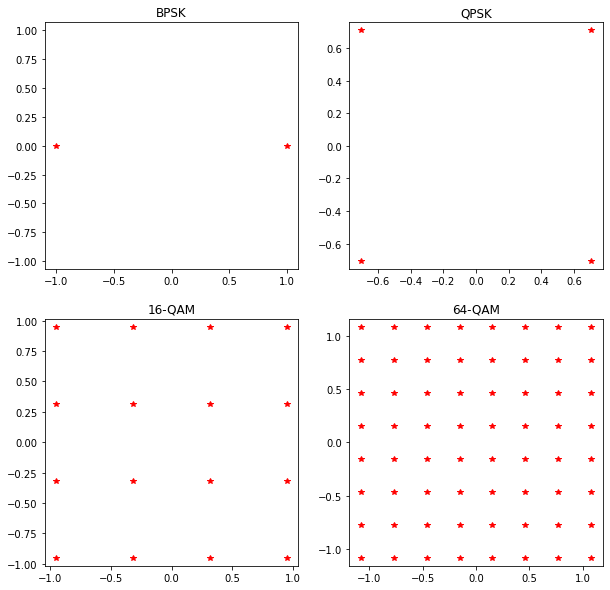

In [2]:
qpsk = QPSK()
bpsk = BPSK()
qam16 = QAM(16)
qam64 = QAM(64)

fig, [[ax11, ax12], [ax21, ax22]] = plt.subplots(figsize=(10, 10),
                                                 nrows=2,
                                                 ncols=2)

ax11.set_title("BPSK")
ax11.plot(bpsk.symbols.real, bpsk.symbols.imag, "*r", label="BPSK")
ax11.axis("equal")

ax12.set_title("QPSK")
ax12.plot(qpsk.symbols.real, qpsk.symbols.imag, "*r", label="QPSK")
ax12.axis("equal")

ax21.set_title("16-QAM")
ax21.plot(qam16.symbols.real, qam16.symbols.imag, "*r", label="16-QAM")
ax21.axis("equal")

ax22.set_title("64-QAM")
ax22.plot(qam64.symbols.real, qam64.symbols.imag, "*r", label="64-QAM")
ax22.axis("equal");

# Transmit though the channel

Now let's see a transmission with QPSK modulation

In [3]:
qpsk = QPSK()
num_symbols = int(1e3)

# We need the data to be in the interval [0, M), where M is the
# number of symbols in the constellation
data_qpsk = np.random.randint(0, qpsk.M, size=num_symbols)
modulated_data_qpsk = qpsk.modulate(data_qpsk)

In [4]:
SNR_dB = 20
snr_linear = dB2Linear(SNR_dB)
noise_power = 1 / snr_linear

# Noise vector
n = math.sqrt(noise_power) * randn_c(num_symbols)

In [5]:
# received_data_qam = su_channel.corrupt_data(modulated_data_qam)
received_data_qpsk = modulated_data_qpsk + n

(-0.9941791935839641,
 1.0165313894292265,
 -0.9810272536115086,
 0.9798690572412926)

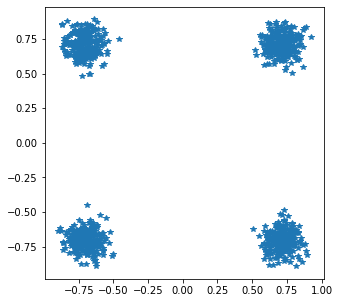

In [6]:
# Received data
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(received_data_qpsk.real, received_data_qpsk.imag, "*")
ax.axis("equal")
# fig.show()

Let's see the obtained error value. However, note that in order to get the proper error value we need to repeat this simulation many times and average the result.

In [7]:
demodulated_data_qpsk = qpsk.demodulate(received_data_qpsk)
symbol_error_rate_qpsk = 1 - sum(
    demodulated_data_qpsk == data_qpsk) / demodulated_data_qpsk.size
print("Error QPSK:", symbol_error_rate_qpsk)

Error QPSK: 0.0


Delete previous variables

In [8]:
del SNR_dB, ax, ax11, ax12, ax21, ax22, bpsk, data_qpsk, demodulated_data_qpsk, fig, modulated_data_qpsk, n, noise_power, num_symbols, qam16, qam64, qpsk, received_data_qpsk, snr_linear, symbol_error_rate_qpsk

# Move code to a function in order to average results

For comparison, let's also create a function to simulate the symbol error rate for a pure AWGN channel.

In [9]:
def simulate_awgn(modulator: Modulator, num_symbols: int, noise_power: float,
                  num_reps: int):
    """Return the symbol error rate"""
    symbol_error_rate = 0.0
    for rep in range(num_reps):
        data = np.random.randint(0, modulator.M, size=num_symbols)
        modulated_data = modulator.modulate(data)

        # Noise vector
        n = math.sqrt(noise_power) * randn_c(num_symbols)

        # received_data_qam = su_channel.corrupt_data(modulated_data_qam)
        received_data = modulated_data + n

        demodulated_data = modulator.demodulate(received_data)
        symbol_error_rate += 1 - sum(
            demodulated_data == data) / demodulated_data.size
    return symbol_error_rate / num_reps

In [10]:
qpsk = QPSK()
num_symbols = int(1e3)

SNR_dB = 5
snr_linear = dB2Linear(SNR_dB)
noise_power = 1 / snr_linear

# We run twice just to check that the number of simulated symbols and repetitions is enouth to get a proper value
symbol_error1 = simulate_awgn(qpsk, num_symbols, noise_power, num_reps=5000)
symbol_error2 = simulate_awgn(qpsk, num_symbols, noise_power, num_reps=5000)

In [11]:
print(f"Obtained symbol error for SNR {SNR_dB}: {symbol_error1}")
print(f"Obtained symbol error for SNR {SNR_dB}: {symbol_error2}")

# Let's print the theoretical value
print(
    f"\nTheoretical symbol error for SNR {SNR_dB}: {qpsk.calcTheoreticalSER(SNR_dB)}"
)

Obtained symbol error for SNR 5: 0.07400820000000001
Obtained symbol error for SNR 5: 0.073906

Theoretical symbol error for SNR 5: 0.07535797629492685


# Simulate for different values of noise power

The previously implemented `simulate_awgn` function is very simple and we only need to call it with different values of noise power to get the values for a "SNR x Symbol Error Rate" plot.

However, this is a good oportunity to see what the classes in the `pyphysim.simulations` module can offer.

To create a "simulator" we need to create a subclass of `pyphysim.simulations.SimulationRunner` and implement the `_run_simulation` method. This method should perform a single iteration (similar to the previous `simulate_awgn` function, but without the loop) and return a `SimulationResults` object containing whatever results you want to save from that iteration. These results will be automatically combined for the many calls of `_run_simulation` method that will be performed when the `simulate` of the `SimulationRunner` base class is called. 

In the `__init__` of your simulator class you must at least do two things: set the desired "simulation parameters" and set a value for `self.rep_max` (default is 1) with the number of times you want to call `_run_simulation`.

In the code below we add a "SNR_db" parameter by calling the `add` method of `self.params` (defined in the base class). The inportant fact here is that we set "SNR_db" as an array with several values, but we set it to be "unpacked", which means that one value should be used at a time.

In [12]:
class AwgnSimulator(SimulationRunner):

    def __init__(self, SINR_dB_values):
        """
        Parameters
        ----------
        SINR_dB_values : np.ndarray
            An array with the several SNR values to simulate
        """
        super().__init__()

        # Add the simulation parameters to the `params` attribute.
        self.params.add('SNR_db', SINR_dB_values)

        # Here we indicate that the SNR_db parameter should be "unpacked". 
        # What that means is that the `current_parameters` argument passed to `_run_simulation` will only have one value
        # and this value will change in subsequent calls to `_run_simulation`
        self.params.set_unpack_parameter('SNR_db')

        # Number of times the `_run_simulation` method will run when `simulate` method is called
        self.rep_max = 500

        # We can save anything that does not change in `_run_simulation` as attributes
        # We could also add the information to `self.params` and buind the modulator inside `_run_simulation`
        self.modulator = QPSK()

    def _run_simulation(self, current_parameters):
        # Since SNR_db is an "unpacked parameter" a single value is passed to `_run_simulation`.
        # We can get the current value as below
        sinr_dB = current_parameters['SNR_db']

        # Number of symbols generated for this realization
        num_symbols = 1000

        # Find the noise power from the SNR value (in dB)
        snr_linear = dB2Linear(sinr_dB)
        noise_power = 1 / snr_linear

        # Generate random transmit data and modulate it
        data = np.random.randint(0, self.modulator.M, size=num_symbols)
        modulated_data = self.modulator.modulate(data)

        # Noise vector
        n = math.sqrt(noise_power) * randn_c(num_symbols)

        # Receive the corrupted data
        received_data = modulated_data + n

        # Demodulate the received data and compute the number of symbol errors
        demodulated_data = self.modulator.demodulate(received_data)
        symbol_errors = sum(demodulated_data != data)

        # Create a SimulationResults object and save the symbol error rate.
        # Note that the symbol error rate is given by the number of symbol errors divided by the number of
        # transmited symbols. We want to combine the symbol error rate for the many calls of `_run_simulation`.
        # Thus, we choose `Result.RATIOTYPE` as the "update_type". See the documentation of the `Result` class
        # for more about it.
        simResults = SimulationResults()
        simResults.add_new_result(
            "symbol_error_rate",
            Result.RATIOTYPE,
            value=symbol_errors,
            total=num_symbols)  # Add one each result you want
        return simResults

Now we can run the simulation. Let's create an AwgnSimulator object and check its parameters.

In [13]:
SNR_db = np.linspace(-5, 15, 9)

runner = AwgnSimulator(SNR_db)
# We can see the simulation parameters using the `params` attribute of the `SimulationRunner`
print(runner.params)

{'SNR_db*': [-5.  -2.5  0.   2.5  5.   7.5 10.  12.5 15. ]}


We have only added the `SNR_db` parameter. The `*` in the name of the `SNR_db` parameter indicates that this parameter will be *unpacked*. This means that the `_run_simulation` method will receive one element of it at a time instead of the whole array.

Now we can finally call the `simulate` method to perform the simulation. Notice the nice progressbar and that we have 9 variations. Each variation corresponds to a different SNR value. If we had added other parameters that should also be unpacked then we would get a different variation for each combination of unpacked parameters.

In [14]:
runner.simulate()

------------- Current Variation: 1/9 -------------
[**********************100%**********************]  Progress
------------- Current Variation: 2/9 -------------
[**********************100%**********************]  Progress
------------- Current Variation: 3/9 -------------
[**********************100%**********************]  Progress
------------- Current Variation: 4/9 -------------
[**********************100%**********************]  Progress
------------- Current Variation: 5/9 -------------
[**********************100%**********************]  Progress
------------- Current Variation: 6/9 -------------
[**********************100%**********************]  Progress
------------- Current Variation: 7/9 -------------
[**********************100%**********************]  Progress
------------- Current Variation: 8/9 -------------
[**********************100%**********************]  Progress
------------- Current Variation: 9/9 -------------
[**********************100%**********************]  P

We can get the simulation results (a SimulationResults object) with the `results` atribute of our simulator object. We can call the `get_result_values_list` method to get the actual values. Let's first check what is stored there.




In [15]:
runner.results

SimulationResults: ['elapsed_time', 'num_skipped_reps', 'symbol_error_rate']

We can see that we have our "symbol_error_rate" result, which is a combination of all the times the `_run_simulation` method was called. Other stored information are the "elapsed_time" and "num_skipped_reps" (more on this one later).


In [16]:
print("Symbol Errors:\n",
      np.array(runner.results.get_result_values_list("symbol_error_rate")))
elapsed_times = runner.results.get_result_values_list("elapsed_time")
print("\nElapsed times:\n", np.array(elapsed_times))

# pretty_time receives a float number corresponding to an elapsed time in seconds and returns a nice string
print(f"\nTotal elapsed time: {pretty_time(sum(elapsed_times))}")

Symbol Errors:
 [4.92e-01 4.02e-01 2.92e-01 1.74e-01 7.37e-02 1.78e-02 1.54e-03 1.80e-05 0.00e+00]

Elapsed times:
 [1.18 1.1  1.17 1.14 1.16 1.3  1.15 1.15 1.18]

Total elapsed time: 10.53s


Now we can finally see the plot and compare the simulated results with theoretical values.

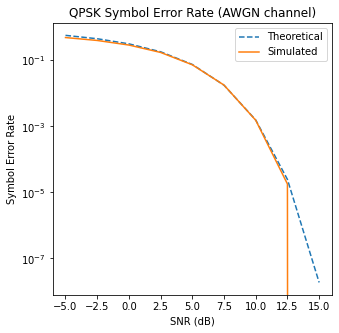

In [17]:
# Now let's plot the results
fig, ax = plt.subplots(figsize=(5, 5))
ax.semilogy(SNR_db, qpsk.calcTheoreticalSER(SNR_db), "--", label="Theoretical")
ax.semilogy(SNR_db,
            runner.results.get_result_values_list("symbol_error_rate"),
            label="Simulated")
ax.set_title("QPSK Symbol Error Rate (AWGN channel)")
ax.set_ylabel("Symbol Error Rate")
ax.set_xlabel("SNR (dB)")
ax.legend();

The simulated values match the theoretical values up to some point, where we can see that we need to simulate more symbols to get the proper symbol error rate. The easy way is to increase the `rep_max` attribute in our simulator, but this will simulate more symbols also for lower SNR values, which will unecesarelly make the simulation slower. Ideally, we want to simulate a large number of symbols for high SNR values and a low number of symbols for low SNR values.

One way to do this is to set `rep_max` to the highest value we want (for the high SNR values) and implement the `_keep_going` method. This method is called each iteration to indicate if we need more iterations of if we can stop early (for a particular variation of parameters). Since we didn't implement it before, the default implementation was used, which just returns True.

The `_keep_going` should be simple to avoid creating unecessary overhead (is cost must be much lower than `_run_simulation`). One possible implementation if to return True as long as the number of cumulative symbol errors is below some value. That is, for low SNR values this value will be reached before the number of times `_run_simulation` is called reach `rep_max`, while for high SNR values this maximum number of sumbol errors might never be reached and `_run_simulation` is called `rep_max` times.

The changed implementation of our simulator is given below.

**Note**: We have set `self.progressbar_message` in the `__init__` method. This allow us to change the message of the progressbar and we can use parameters names in the message, which is automatically replaced by the current value (if unpacked).

In [18]:
class AwgnSimulator2(SimulationRunner):

    def __init__(self, SINR_dB_values):
        super().__init__()

        # Add the simulation parameters to the `params` attribute.
        self.params.add('SNR_db', SINR_dB_values)

        # Here we indicate that the SNR_db parameter should be "unpacked". 
        # What that means is that the `current_parameters` argument passed to `_run_simulation` will only have one value
        # and this value will change in subsequent calls to `_run_simulation`
        self.params.set_unpack_parameter('SNR_db')

        # Number of times the `_run_simulation` method will run when `simulate` method is called.
        # We are using a value 100 times larger than before, but the simulation will not take
        # 100 times the previous elapsed time to finish thanks to the implementation of the
        # `_keep_going` method that will allow us to skip many of these iterations for low SNR values
        self.rep_max = 50000

        # Number of symbols generated for this realization
        self.num_symbols = 1000

        # Used in the implementation of `_keep_going` method. This is the maximum numbers of symbol
        # errors we allow before `_run_simulation` is stoped for a given configuration
        self.max_symbol_errors = 1. / 1000. * self.num_symbols * self.rep_max

        # We can save anything that does not change in `_run_simulation` as attributes
        self.modulator = QPSK()

        # Set a nice message for the progressbar
        self.progressbar_message = "Simulating for SNR {SNR_db}"

        # Change the progressbar "style" to something nicer for the notebook
        # Possible values are 'text1', 'text2' and 'ipython'
        self.update_progress_function_style = "ipython"

    def _keep_going(self, current_params, current_sim_results, current_rep):
        # Note that we have added a "symbol_errors" result in `_run_simulation` to use here

        # Get the last value in the "symbol_errors" results list, which corresponds to the current configuration
        cumulated_symbol_errors \
            = current_sim_results['symbol_errors'][-1].get_result()
        return cumulated_symbol_errors < self.max_symbol_errors

    def _run_simulation(self, current_parameters):
        # Since SNR_db is an "unpacked parameter" a single value is passed to `_run_simulation`.
        # We can get the current value as below
        sinr_dB = current_parameters['SNR_db']

        # Find the noise power from the SNR value (in dB)
        snr_linear = dB2Linear(sinr_dB)
        noise_power = 1 / snr_linear

        # Generate random transmit data and modulate it
        data = np.random.randint(0, self.modulator.M, size=self.num_symbols)
        modulated_data = self.modulator.modulate(data)

        # Noise vector
        n = math.sqrt(noise_power) * randn_c(self.num_symbols)

        # Receive the corrupted data
        received_data = modulated_data + n

        # Demodulate the received data and compute the number of symbol errors
        demodulated_data = self.modulator.demodulate(received_data)
        symbol_errors = sum(demodulated_data != data)

        # Create a SimulationResults object and save the symbol error rate.
        # Note that the symbol error rate is given by the number of symbol errors divided by the number of
        # transmited symbols. We want to combine the symbol error rate for the many calls of `_run_simulation`.
        # Thus, we choose `Result.RATIOTYPE` as the "update_type". See the documentation of the `Result` class
        # for more about it.
        simResults = SimulationResults()
        simResults.add_new_result("symbol_error_rate",
                                  Result.RATIOTYPE,
                                  value=symbol_errors,
                                  total=self.num_symbols)
        simResults.add_new_result("symbol_errors",
                                  Result.SUMTYPE,
                                  value=symbol_errors)
        return simResults

Now we can run the simulation. We will also call the `set_results_filename` so that the results are saved to the disk. The results will be saved using pickle. Furthermore, partial results are also saved (inside a "partial_results" folder) and you can interrupt the simulation and continue from where it was interrupted.

If you do not set the results filename before starting the simulation, you can also save the results by calling the `save_to_file` method of the `runner2.results` object (although in this case partial results will not be saved during the simulation).

In [19]:
runner2 = AwgnSimulator2(SNR_db)
# Set the name name of the results file
# If the file extension is not provided, then pickle will be used to save the results
# If an extension is provided, it can be either 'pickle' or 'json'
runner2.set_results_filename("results_qpsk_awgn")
runner2.simulate()

Calling again will simply load the results from the file and it should be very fast.

In [20]:
runner2.simulate()

In [21]:
# However, if you increase the value of rep_max and run the `simulate` method again
# it will run only the remaining iterations
runner2.rep_max += 2000
runner2.simulate()

As before we have the "symbol_error_rate", "elapsed_time" and "num_skipped_reps" results.

In [22]:
runner2.results

SimulationResults: ['elapsed_time', 'num_skipped_reps', 'symbol_error_rate', 'symbol_errors']

In [23]:
print(runner2.results.get_result_values_list("num_skipped_reps"))

[0, 0, 0, 0, 0, 0, 0, 0, 0]


The "num_skipped_reps" results indicate how many iterations were skiped due to a `SkipThisOne` exception being raised in the `_run_simulation` method for some reason. It is not related to the simulation being stopped ealier due to `_keep_going` returning `False`. If you need to know how many iterations were run just add a result in `_run_simulation` to track that.

In [24]:
print("Symbol Errors:\n",
      np.array(runner2.results.get_result_values_list("symbol_error_rate")))
elapsed_times2 = runner2.results.get_result_values_list("elapsed_time")
print("\nElapsed times:\n", np.array(elapsed_times2))

# pretty_time receives a float number corresponding to an elapsed time in seconds and returns a nice string
print(f"\nTotal elapsed time: {pretty_time(sum(elapsed_times2))}")

Symbol Errors:
 [4.91e-01 4.02e-01 2.90e-01 1.74e-01 7.40e-02 1.76e-02 1.58e-03 2.40e-05 1.92e-08]

Elapsed times:
 [  0.21   0.24   0.45   0.59   1.47   7.06  72.12 119.8  122.22]

Total elapsed time: 5m:24s


Notice the elapsed times for the low SNR values. The simulation was very fast for low SNR values, while for high SNR values it took longer. You can compare this to the case where the `_keep_going` method was not implemented and the elapsed time was approximatelly the same for all SNR values.

Let's plot the results with the new simulation.

In [25]:
SNR_db

array([-5. , -2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. ])

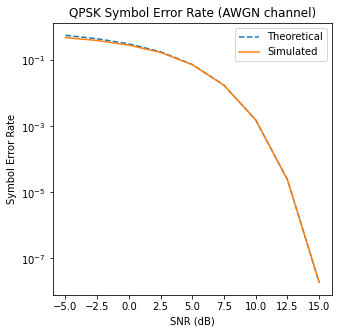

In [26]:
# Now let's plot the results
fig, ax = plt.subplots(figsize=(5, 5))
ax.semilogy(SNR_db, qpsk.calcTheoreticalSER(SNR_db), "--", label="Theoretical")
ax.semilogy(SNR_db,
            runner2.results.get_result_values_list("symbol_error_rate"),
            label="Simulated")
ax.set_title("QPSK Symbol Error Rate (AWGN channel)")
ax.set_ylabel("Symbol Error Rate")
ax.set_xlabel("SNR (dB)")
ax.legend();

Now the simulated symbol error rate match the theoretical value also in the high SNR regime.

# Run simulations in parallel

By implementing a subclass of `SimulationRunner` you also gain the possibility of running the different configurations (different SNR values in our case) in parallel by using the `simulate_in_parallel` method, instead of `simulate`. This parallel computation is performed using the `ipyparallel` library, which is an optional dependency of `pyphysim`. 

See the [Transmission_with_Rayleigh_and_AWGN_channels](Transmission_with_Rayleigh_and_AWGN_channels.ipynb) notebook for an example that performs simulations in parallel.


**Note**: When running in parallel only a single progressbar will be presented, but it will account the progress of all running configurations.

# Using saved results from a simulation

The `results` atribute of the simulator (the `runner2` object in this notebook) is an instance of the `SimulationResults` class. There are a few ways to get the values stored in it. To see which results are stored in the `results` object we can call the `get_result_names` method.

In [27]:
runner2.results.get_result_names()

['symbol_error_rate', 'symbol_errors', 'elapsed_time', 'num_skipped_reps']

We can index this object with the name of the desired result.

In [28]:
runner2.results["elapsed_time"]

[Result -> elapsed_time: 0.20981049537658691,
 Result -> elapsed_time: 0.2427213191986084,
 Result -> elapsed_time: 0.45435571670532227,
 Result -> elapsed_time: 0.5926723480224609,
 Result -> elapsed_time: 1.4656848907470703,
 Result -> elapsed_time: 7.056248903274536,
 Result -> elapsed_time: 72.12221837043762,
 Result -> elapsed_time: 119.8037121295929,
 Result -> elapsed_time: 122.21845483779907]

This yeilds a list of `Result` objects (see the help of the `Result class for more`), but if you just want the values then call the `get_result_values_list` method of the `SimulationResults` class instead.

In [29]:
# Get the elapsed time of each configuration (each SNR in our case)
runner2.results.get_result_values_list("elapsed_time")

[0.20981049537658691,
 0.2427213191986084,
 0.45435571670532227,
 0.5926723480224609,
 1.4656848907470703,
 7.056248903274536,
 72.12221837043762,
 119.8037121295929,
 122.21845483779907]

You can also get the confidence interval of some result with the `get_result_values_confidence_intervals` method. You can even use the confidence interval in the implementation of the `_keep_going` method, if you want.

In [30]:
runner2.results.get_result_values_confidence_intervals("symbol_error_rate")

[(0.4883117978827526, 0.4939823197643062),
 (0.399371746528551, 0.404564253471449),
 (0.2882075005801296, 0.29245145895744257),
 (0.17274459388963365, 0.1755679061103662),
 (0.0734197600734171, 0.07463349436445313),
 (0.017432923843822248, 0.01773303958796422),
 (0.0015620721459866176, 0.001589618736171652),
 (2.2707996796215086e-05, 2.536892628070698e-05),
 (-1.8461176033760512e-08, 5.6922714495298977e-08)]

To save the results to a file you can use `save_to_file` method of `SimulationResults`. That was already done for us in the end of the simulation, since we have called the `set_results_filename` method of our simulator. 

Once you have a file with the saved results you can load its data using the `SimulationResults.load_from_file`. This returns a `SimulationResults` object with the loaded data and you can use the previously discussed ways to access its data.

In [31]:
# If the filename is provided without extension, then 'pickle' is assumed as the file extension
results = SimulationResults.load_from_file("results_qpsk_awgn")
results

SimulationResults: ['elapsed_time', 'num_skipped_reps', 'symbol_error_rate', 'symbol_errors']

Another way to use the data in a `SimulationResults` object is calling its `to_dataframe` method. It will create a (https://pandas.pydata.org/)[pandas] `DataFrame` with the data in the `SimulationResults` object. This required the `pandas` library to be installed.

In [32]:
results.to_dataframe()

,SNR_db,rep_max,symbol_error_rate,symbol_errors,elapsed_time,num_skipped_reps,runned_reps
0,-5.0,52000,4.911471e-01,50097,0.209810,0,102
1,-2.5,52000,4.019680e-01,50246,0.242721,0,125
2,0.0,52000,2.903295e-01,50227,0.454356,0,173
3,2.5,52000,1.741563e-01,50157,0.592672,0,288
4,5.0,52000,7.402663e-02,50042,1.465685,0,676
5,7.5,52000,1.758298e-02,50006,7.056249,0,2844
6,10.0,52000,1.575845e-03,50000,72.122218,0,31729
7,12.5,52000,2.403846e-05,1250,119.803712,0,52000
8,15.0,52000,1.923077e-08,1,122.218455,0,52000


Notice that besides the simulation results, the dataframe also includes the simulation parameters (`SNR_db` in our case) as well as the number of runned repetitions, skipped repetitions, and the elapsed time.

Indeed, the `SimulationResults` object stores all of this information. Particularly, the `params` attribute has all the simulation parameters. This allow you to have all necessary information of a simulation from the saved results file.

In [33]:
results.params

{'SNR_db*': [-5.  -2.5  0.   2.5  5.   7.5 10.  12.5 15. ], 'rep_max': 52000}

# Final Note

This notebook illustrated how to create simulators in `pyphysim`, but it only touched a very small part of functionality to simulate physical layer transmission in wireless communications. You can explore the classes in `pyphysim` for other functionality such as other channels, MIMO transmission, etc.. In general you can addapt code here to simulate other scenarios by just changing the implementation of the `_run_simulation` and `_keep_going` methods.

See the notebook [Transmission_with_Rayleigh_and_AWGN_channels](Transmission_with_Rayleigh_and_AWGN_channels.ipynb) for a simulation with Rayleigh channel and different QAM constelation sizes.